In [1]:
import networkx as nx
import pandas as pd
from community import community_louvain

In [3]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

# Assuming the CSV file is named "X-IIoTID.csv" and located in the current directory.
df = pd.read_csv('X-IIoTID.csv', low_memory=False)
# Print all column names to identify the timestamp column
print(df.columns)


Index(['Date', 'Timestamp', 'Scr_IP', 'Scr_port', 'Des_IP', 'Des_port',
       'Protocol', 'Service', 'Duration', 'Scr_bytes', 'Des_bytes',
       'Conn_state', 'missed_bytes', 'is_syn_only', 'Is_SYN_ACK',
       'is_pure_ack', 'is_with_payload', 'FIN or RST', 'Bad_checksum',
       'is_SYN_with_RST', 'Scr_pkts', 'Scr_ip_bytes', 'Des_pkts',
       'Des_ip_bytes', 'anomaly_alert', 'total_bytes', 'total_packet',
       'paket_rate', 'byte_rate', 'Scr_packts_ratio', 'Des_pkts_ratio',
       'Scr_bytes_ratio', 'Des_bytes_ratio', 'Avg_user_time', 'Std_user_time',
       'Avg_nice_time', 'Std_nice_time', 'Avg_system_time', 'Std_system_time',
       'Avg_iowait_time', 'Std_iowait_time', 'Avg_ideal_time',
       'Std_ideal_time', 'Avg_tps', 'Std_tps', 'Avg_rtps', 'Std_rtps',
       'Avg_wtps', 'Std_wtps', 'Avg_ldavg_1', 'Std_ldavg_1', 'Avg_kbmemused',
       'Std_kbmemused', 'Avg_num_Proc/s', 'Std_num_proc/s', 'Avg_num_cswch/s',
       'std_num_cswch/s', 'OSSEC_alert', 'OSSEC_alert_level', 'Lo

In [6]:
import pandas as pd
import networkx as nx

# Load the dataset
df = pd.read_csv('X-IIoTID.csv', low_memory=False)

# Attempt to convert the 'Timestamp' column to numeric, coercing errors to NaN
df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')

# Optionally, filter out rows with NaN timestamps if you don't want to include them in your analysis
df.dropna(subset=['Timestamp'], inplace=True)

# Now, safely convert Unix timestamp (assumed to be in seconds) to datetime
df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s').dt.round('H')

# Continue with the creation of snapshots and graphs as previously described
snapshots = {}
node_ids = {}
current_id = 1

for index, row in df.iterrows():
    snapshot_id = row['timestamp']
    if snapshot_id not in snapshots:
        snapshots[snapshot_id] = nx.Graph()
    
    for ip in [row['Scr_IP'], row['Des_IP']]:
        if ip not in node_ids:
            node_ids[ip] = current_id
            current_id += 1
        if node_ids[ip] not in snapshots[snapshot_id]:
            snapshots[snapshot_id].add_node(node_ids[ip], ip=ip)
    snapshots[snapshot_id].add_edge(node_ids[row['Scr_IP']], node_ids[row['Des_IP']], weight=1)

# Print basic information about each snapshot
for timestamp, graph in snapshots.items():
    print(f"Snapshot at {timestamp}:")
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")
    print("---")


Snapshot at 2020-01-09 04:00:00:
Number of nodes: 29
Number of edges: 35
---
Snapshot at 2020-01-13 00:00:00:
Number of nodes: 31
Number of edges: 40
---
Snapshot at 2020-01-08 22:00:00:
Number of nodes: 23
Number of edges: 27
---
Snapshot at 2020-02-26 23:00:00:
Number of nodes: 23
Number of edges: 29
---
Snapshot at 2019-12-16 00:00:00:
Number of nodes: 26
Number of edges: 33
---
Snapshot at 2020-01-31 07:00:00:
Number of nodes: 23
Number of edges: 23
---
Snapshot at 2019-12-11 22:00:00:
Number of nodes: 27
Number of edges: 34
---
Snapshot at 2020-02-20 23:00:00:
Number of nodes: 21
Number of edges: 26
---
Snapshot at 2019-12-16 04:00:00:
Number of nodes: 32
Number of edges: 40
---
Snapshot at 2020-02-24 01:00:00:
Number of nodes: 21
Number of edges: 25
---
Snapshot at 2020-01-07 05:00:00:
Number of nodes: 32
Number of edges: 41
---
Snapshot at 2019-12-18 00:00:00:
Number of nodes: 30
Number of edges: 42
---
Snapshot at 2020-02-03 17:00:00:
Number of nodes: 23
Number of edges: 28
---

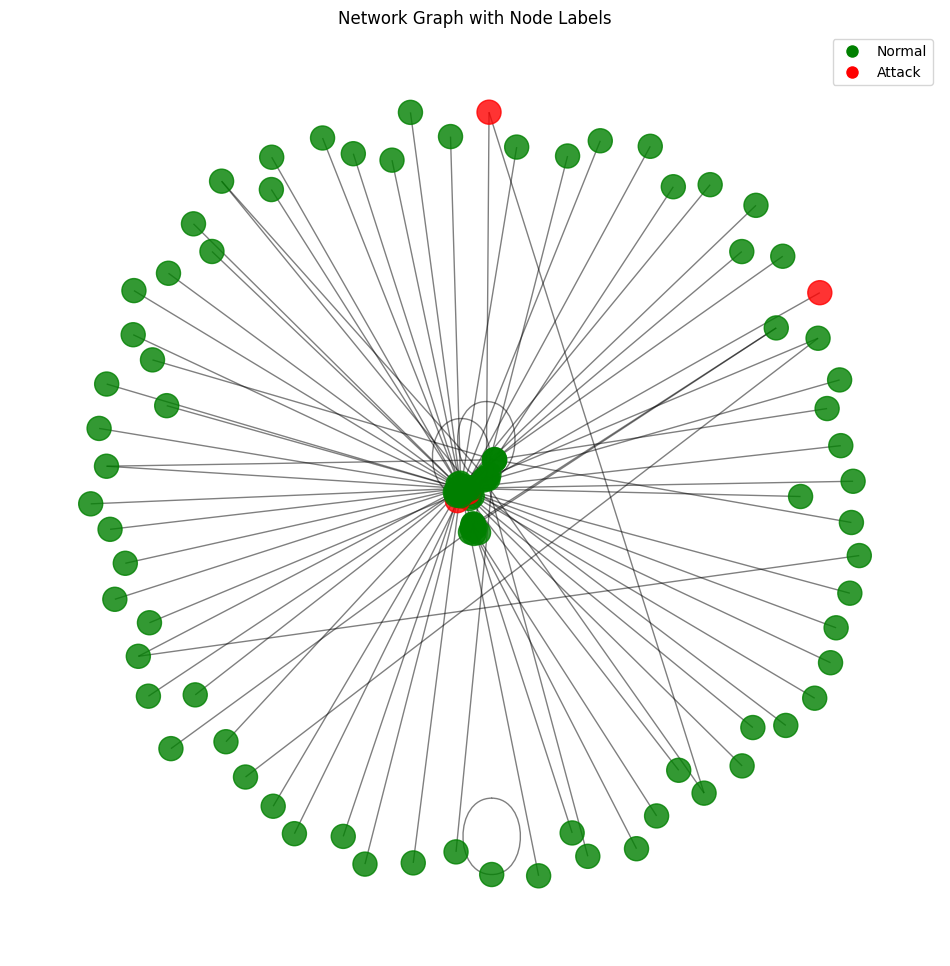

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from collections import defaultdict
from matplotlib import cm

# Load the dataset
df = pd.read_csv('X-IIoTID.csv', low_memory=False)

# Preprocess the dataset
df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
df.dropna(subset=['Timestamp'], inplace=True)
df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s').dt.round('H')

# Initialize an undirected graph
G = nx.Graph()

# Add edges and nodes to the graph, ensuring all nodes have a 'label'
for index, row in df.iterrows():
    src_bytes = int(row['Scr_bytes']) if row['Scr_bytes'].isdigit() else 0
    des_bytes = int(row['Des_bytes']) if row['Des_bytes'].isdigit() else 0
    total_bytes = src_bytes + des_bytes

    if row['Scr_IP'] not in G:
        G.add_node(row['Scr_IP'], label=row['class3'])
    if row['Des_IP'] not in G:
        G.add_node(row['Des_IP'], label='Normal')  # Adjust based on your dataset

    G.add_edge(
        row['Scr_IP'],
        row['Des_IP'],
        weight=total_bytes,
        protocol=row['Protocol'],
        src_port=row['Scr_port'],
        des_port=row['Des_port'],
        service=row.get('Service', None)
    )

# Detect communities using the Louvain method
partition = community_louvain.best_partition(G, weight='weight')

# Visualization
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

# Color nodes based on their label
node_colors = [G.nodes[node]['label'] for node in G]
colors = {'Normal': 'green', 'Attack': 'red'}
node_colors = [colors[label] if label in colors else 'gray' for label in node_colors]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Create legend for node labels
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=val) 
                   for key, val in colors.items()]
plt.legend(handles=legend_elements, loc='best')

plt.title('Network Graph with Node Labels')
plt.axis('off')
plt.show()



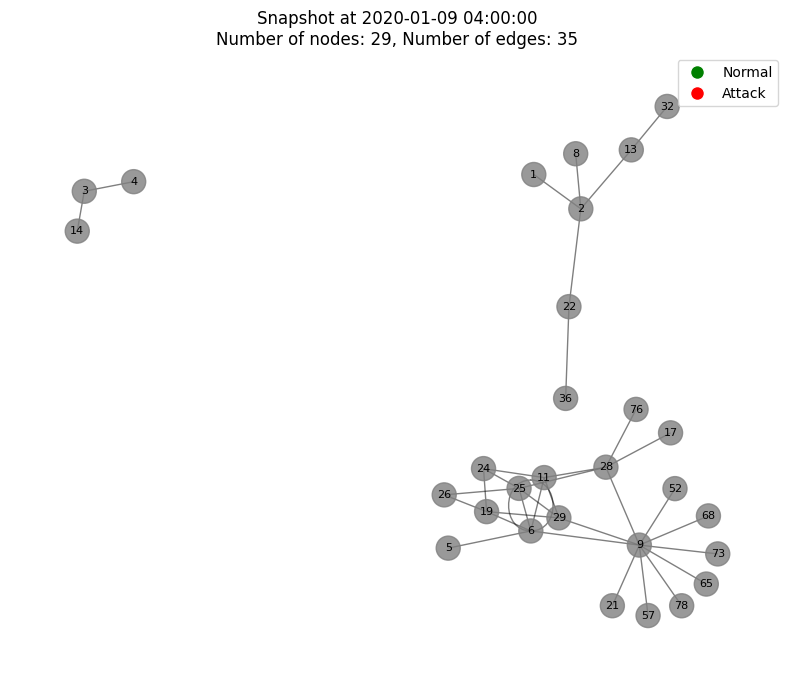

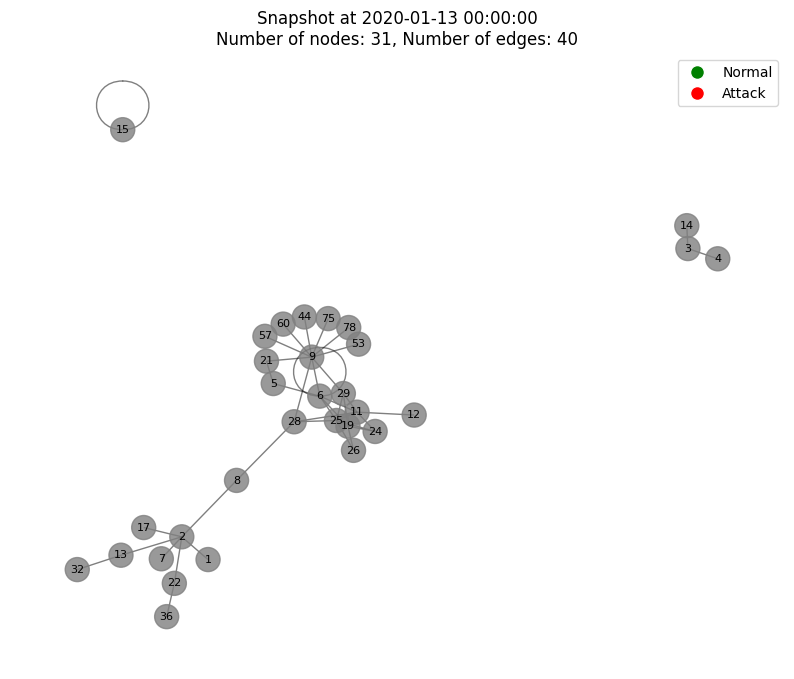

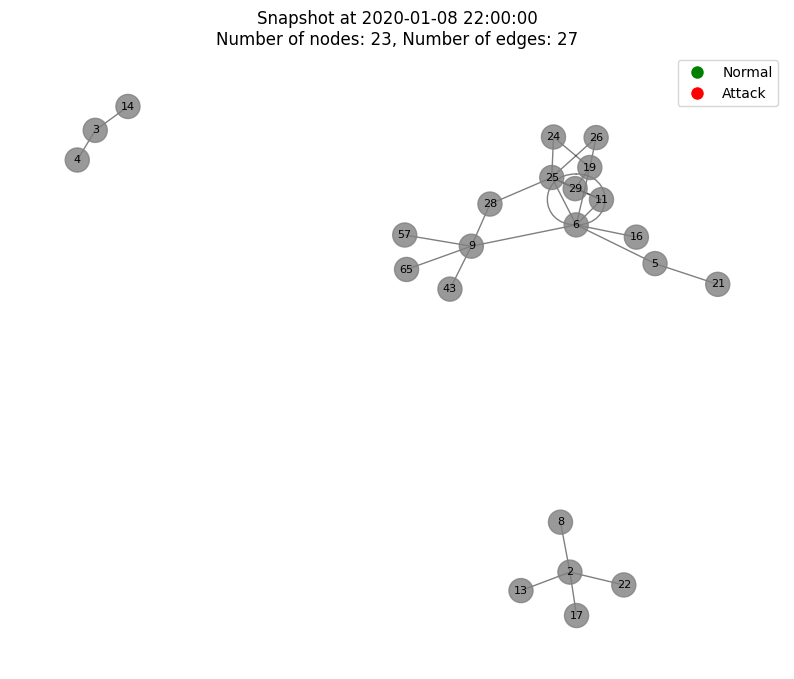

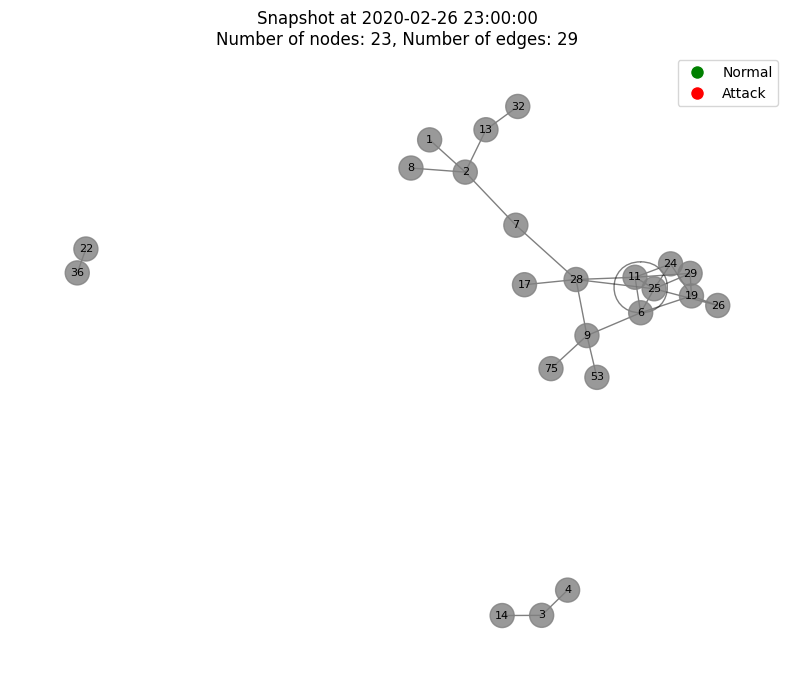

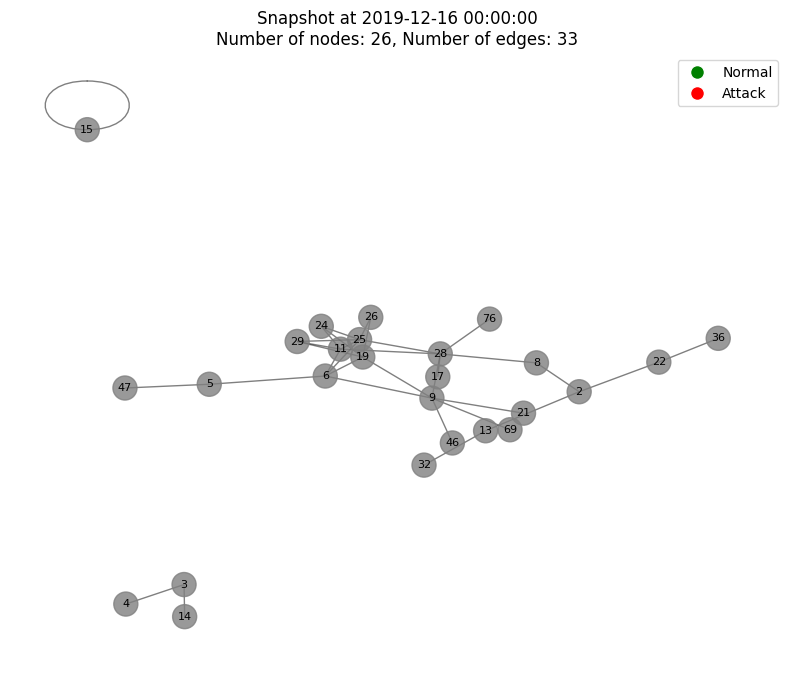

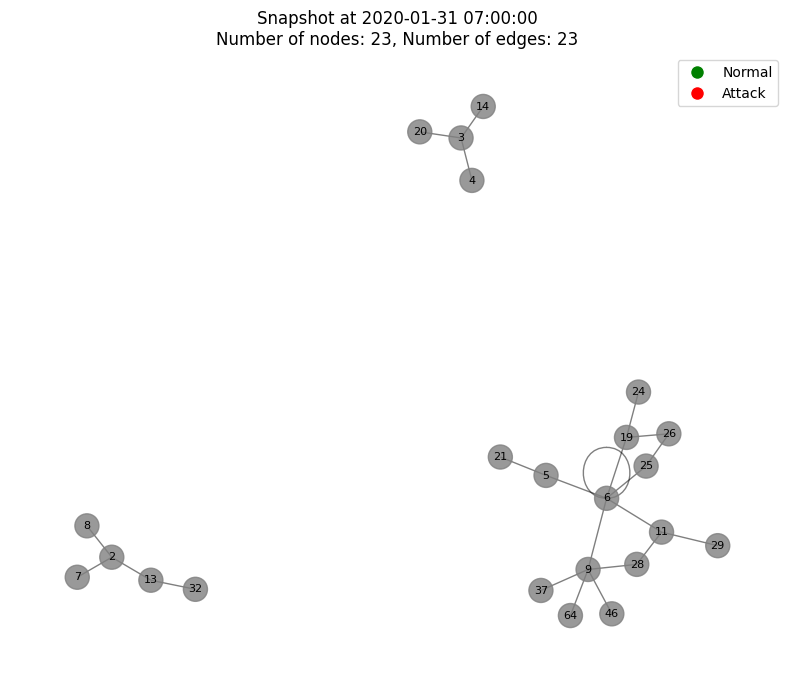

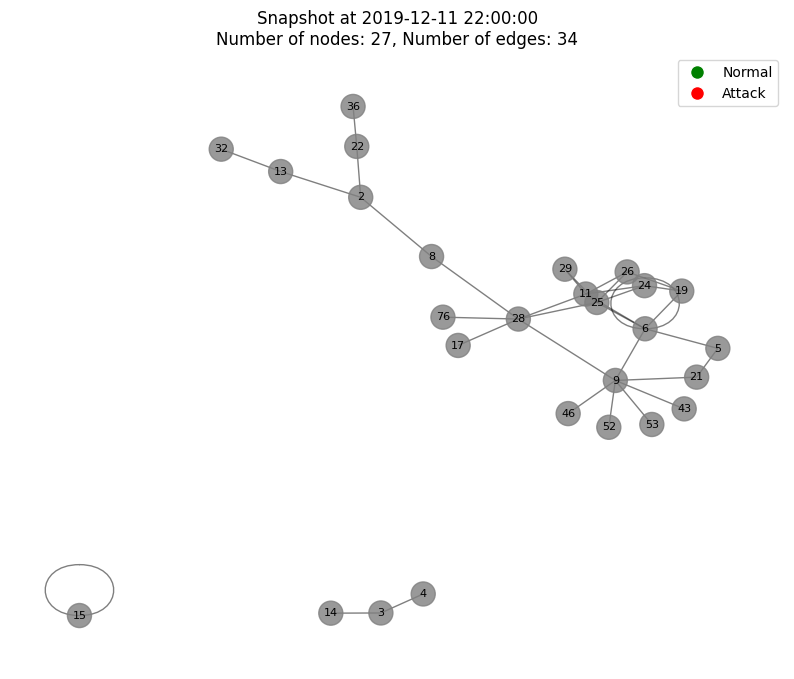

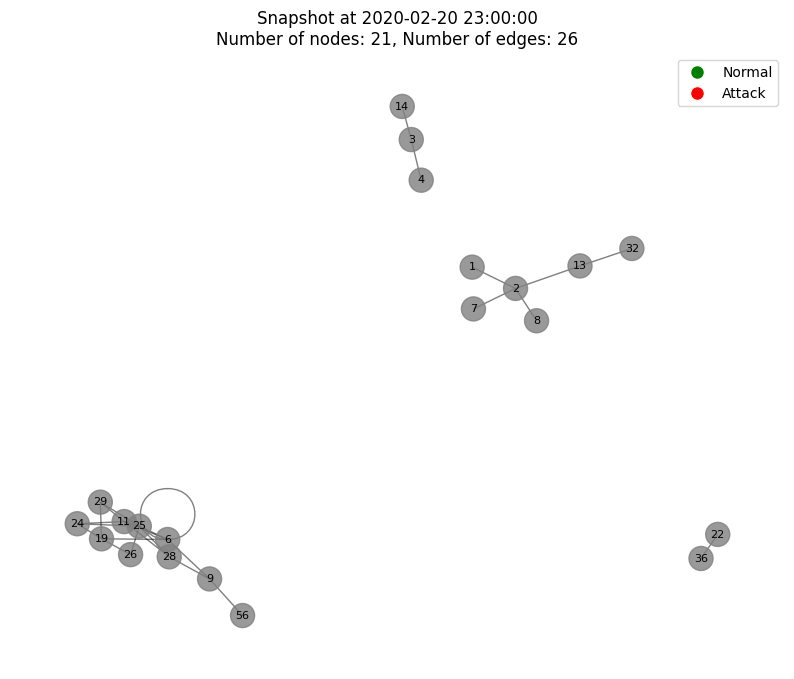

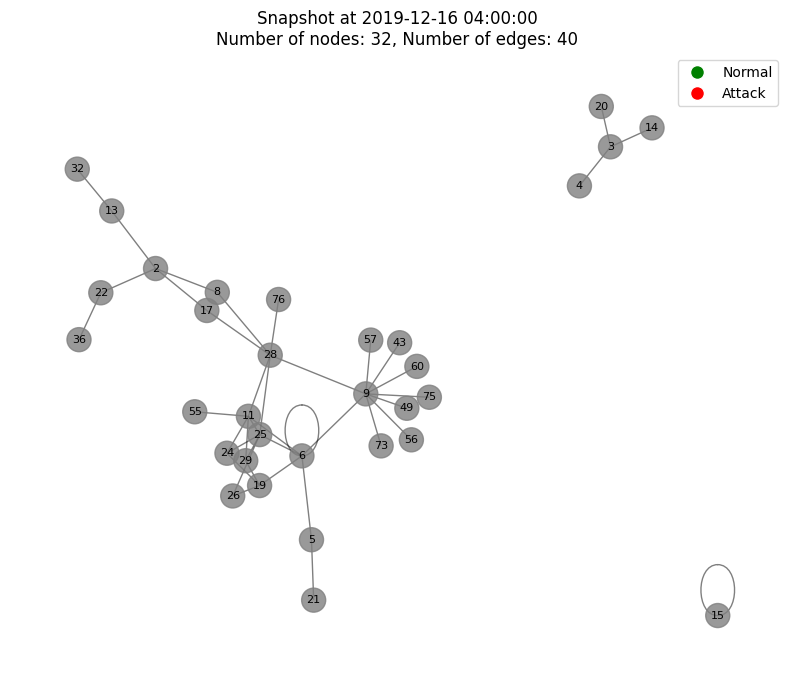

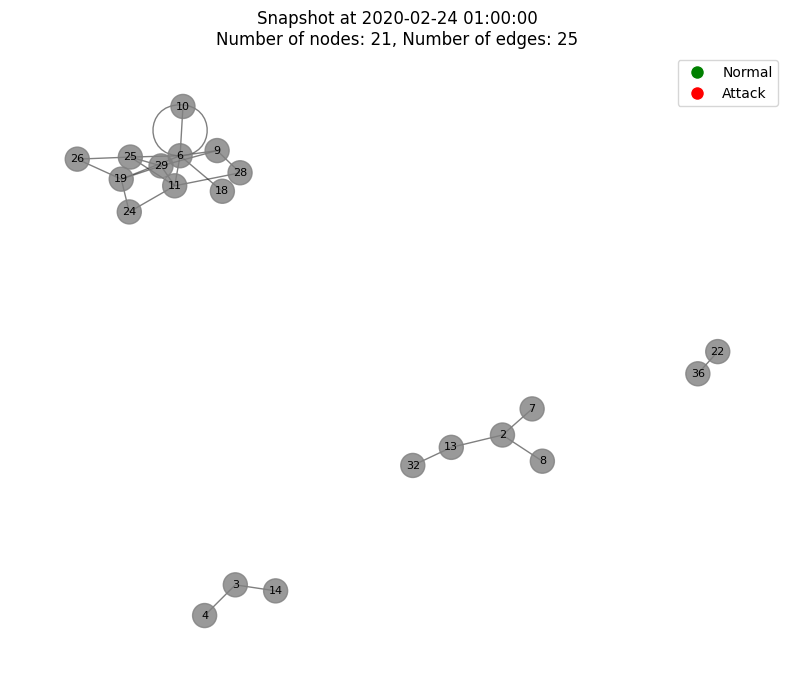

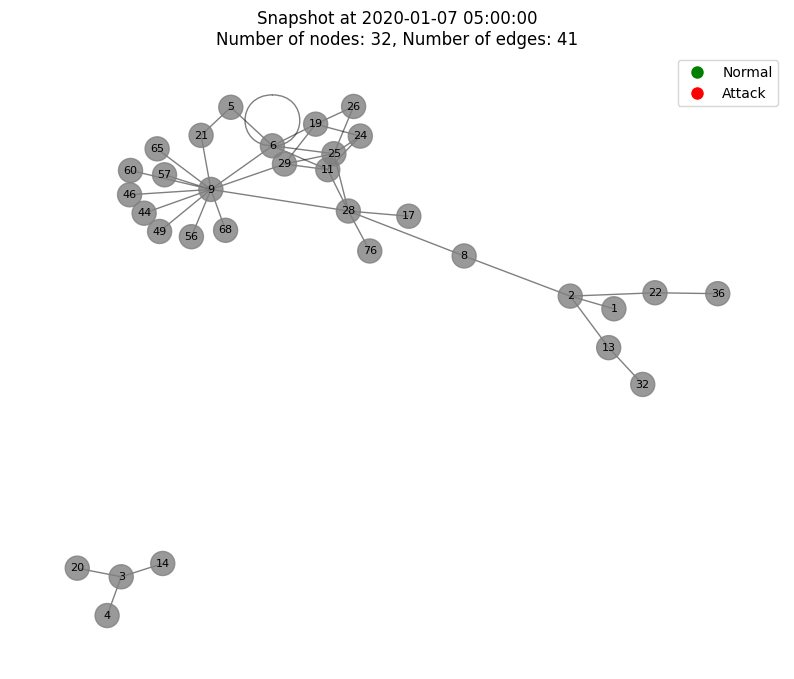

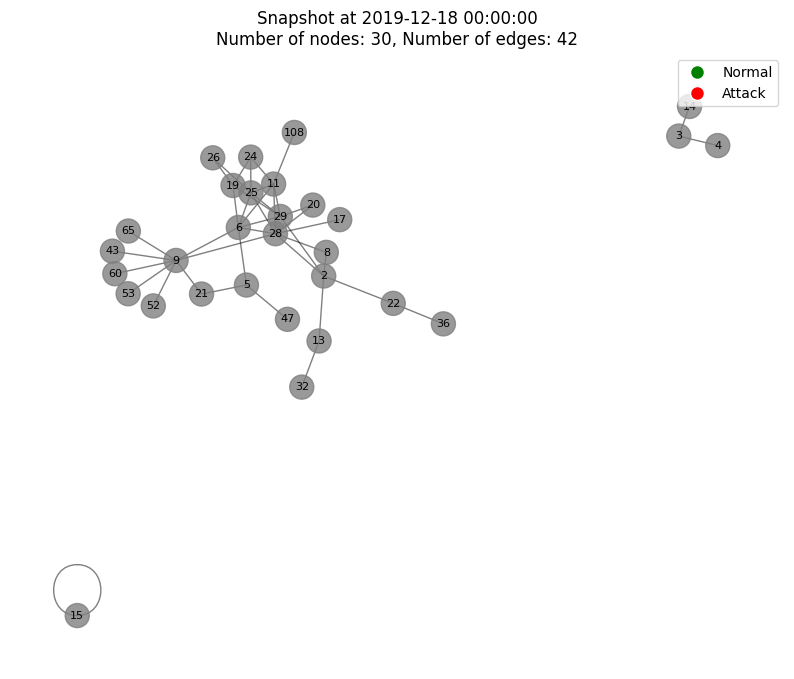

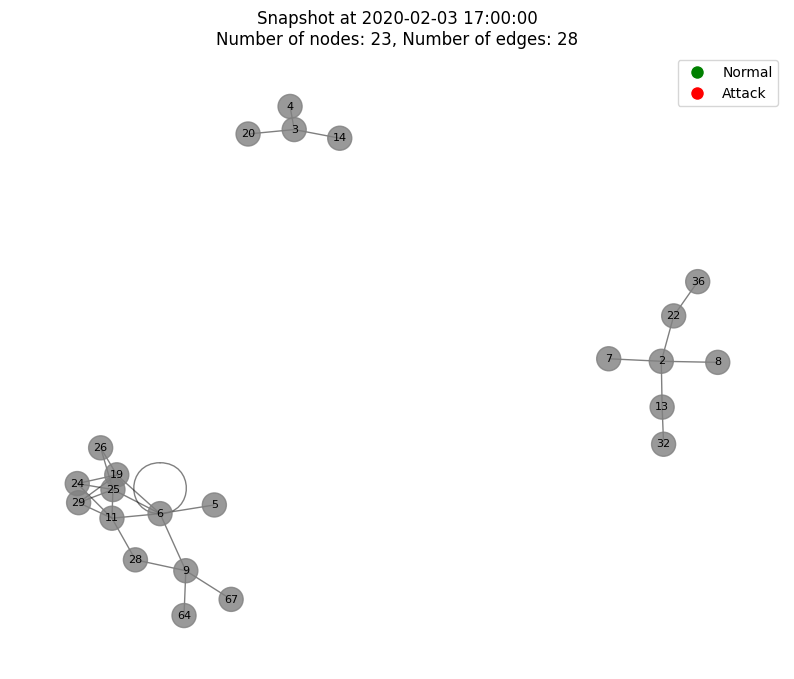

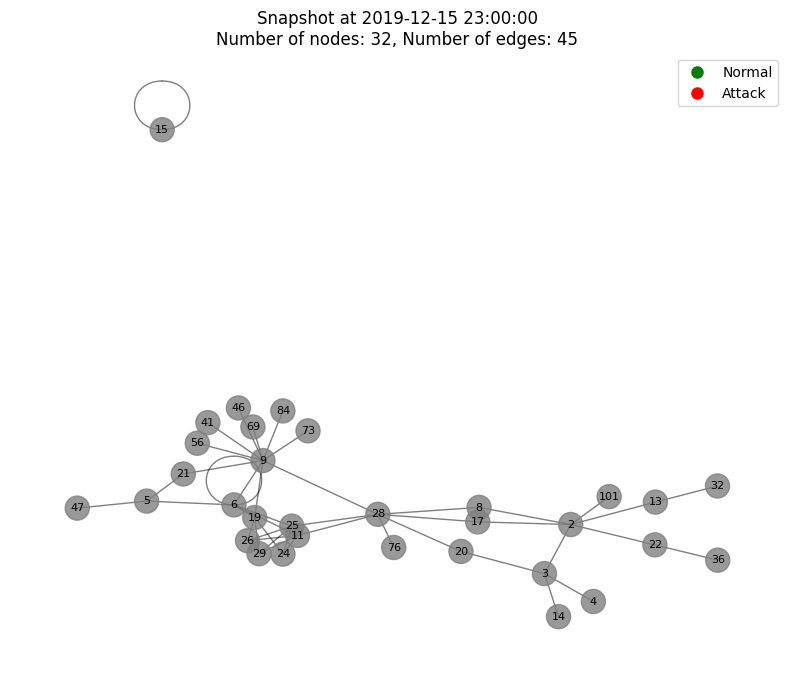

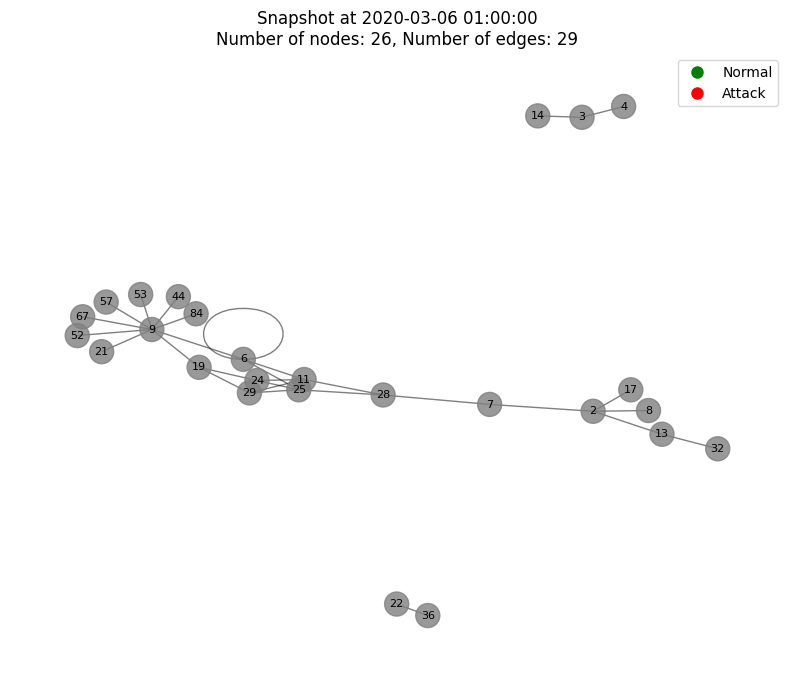

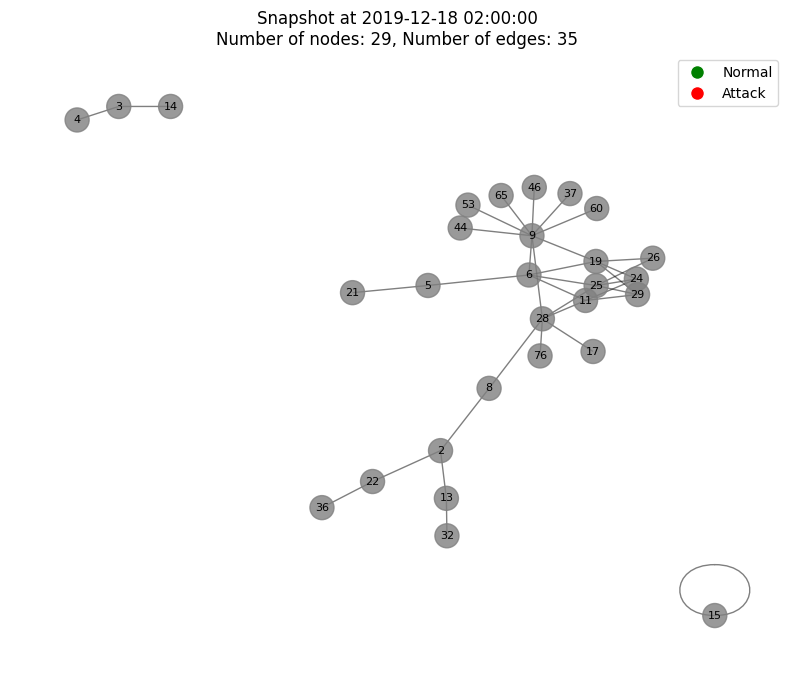

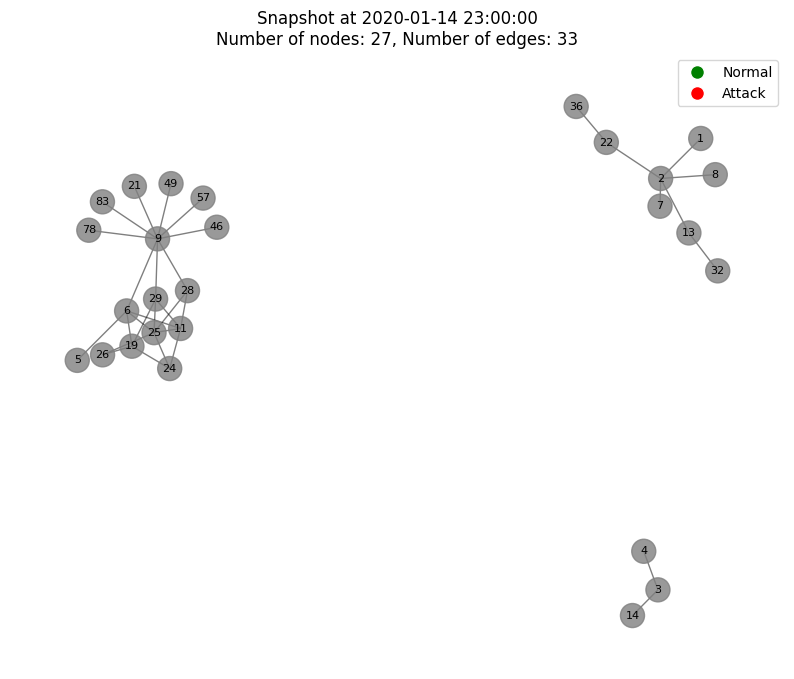

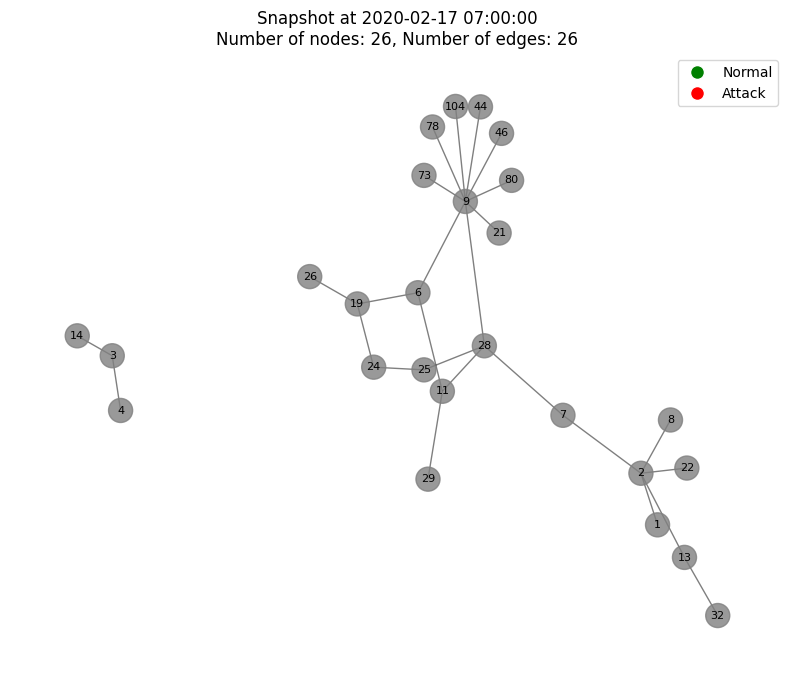

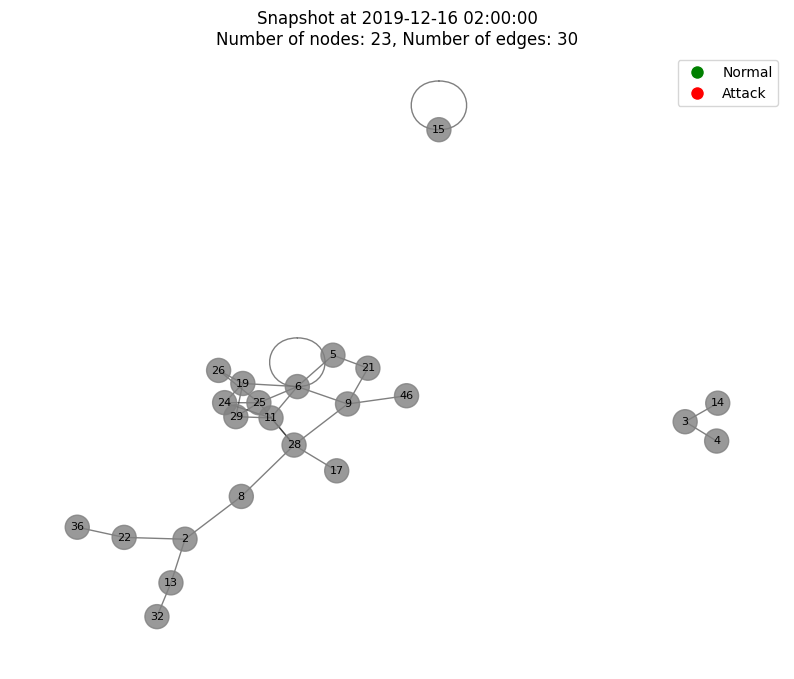

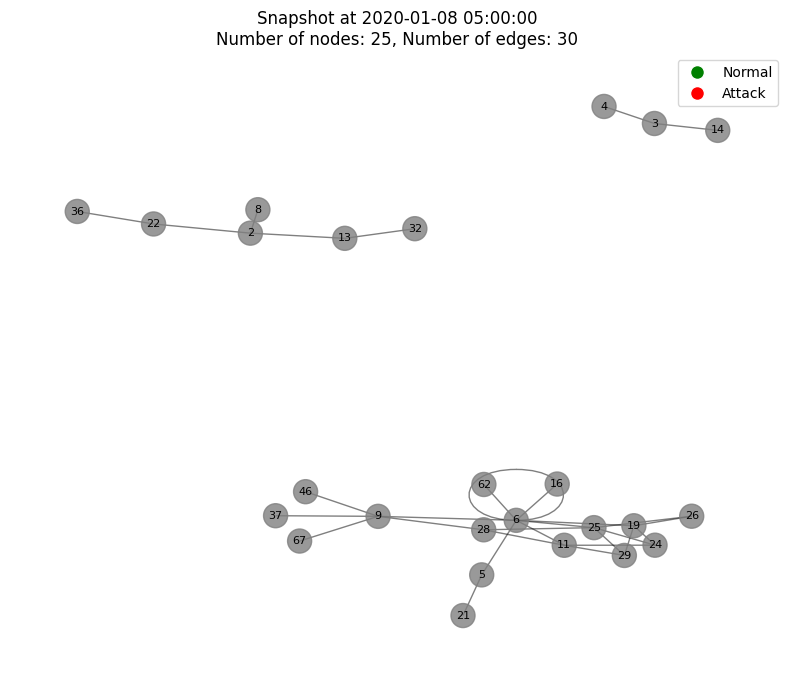

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming the 'snapshots' dictionary has been created as per the previous steps

# Set a limit on the number of snapshots to visualize if there are many
max_snapshots_to_visualize = 20  # Adjust as needed

# Function to define colors based on node labels
def get_node_color(node, graph):
    if 'label' in graph.nodes[node]:
        return 'green' if graph.nodes[node]['label'] == 'Normal' else 'red'
    return 'gray'  # Default color if no label is present

# Visualization loop for each snapshot
for i, (timestamp, graph) in enumerate(snapshots.items()):
    if i >= max_snapshots_to_visualize:
        break  # Stops the loop if the maximum number of visualizations is reached
    
    plt.figure(figsize=(10, 8))
    plt.title(f'Snapshot at {timestamp}\nNumber of nodes: {graph.number_of_nodes()}, Number of edges: {graph.number_of_edges()}')

    # Compute the layout for visualizing the graph
    pos = nx.spring_layout(graph)
    
    # Prepare color map for nodes based on their label
    node_colors = [get_node_color(node, graph) for node in graph.nodes()]

    # Draw nodes and edges
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=8, font_color='black')

    # Create legend for the colors
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Normal'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Attack')
    ]
    plt.legend(handles=legend_elements, loc='best')

    plt.axis('off')  # Hides the axis
    plt.show()


In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming the 'snapshots' dictionary has been created

# Initialize counters for labels
label_counts = {'Normal': 0, 'Attack': 0, 'Unlabeled/Other': 0}

# Loop through each snapshot to count labels
for timestamp, graph in snapshots.items():
    for node in graph.nodes(data=True):
        label = node[1].get('label', 'Unlabeled/Other')  # Get the label of the node, default to 'Unlabeled/Other'
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts['Unlabeled/Other'] += 1

# Print out the counts of each label
print("Label counts across all snapshots:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# Continue with visualization as before


Label counts across all snapshots:
Normal: 0
Attack: 0
Unlabeled/Other: 5915
